In [1]:
# import libraries

import torch
import torch.nn as nn

from torchvision import transforms, datasets
import torch.nn.functional as F
import torch.optim as optim


import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.distributions import Normal, Bernoulli, Independent
from collections import defaultdict

In [2]:
device ='cuda'

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images to [-1, 1]
])

train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False,
                                download=True, transform=transform)

train_loader =  torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader =  torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 170498071/170498071 [00:05<00:00, 29942214.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
def get_normal_KL(mean_1, log_std_1, mean_2=None, log_std_2=None):
    """
        This function should return the value of KL(p1 || p2),
        where p1 = Normal(mean_1, exp(log_std_1)), p2 = Normal(mean_2, exp(log_std_2) ** 2).
        If mean_2 and log_std_2 are None values, we will use standard normal distribution.
        Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)

    std_1 = torch.exp(log_std_1)
    std_2 = torch.exp(log_std_2)

    mean_1, mean_2 = mean_1.float(), mean_2.float()
    std_1, std_2  = std_1.float(), std_2.float()

    p  = Independent(torch.distributions.Normal(mean_1, std_1), 1)
    q  = Independent(torch.distributions.Normal(mean_2, std_2), 1)
    kl = torch.distributions.kl_divergence(p, q)

    return kl

def get_normal_nll(x, mean, log_std):
    """
        This function should return the negative log likelihood log p(x),
        where p(x) = Normal(x | mean, exp(log_std) ** 2).
        Note that we consider the case of diagonal covariance matrix.
    """
    # ====
    mean = mean.float()
    std  = torch.exp(log_std).float()

    prob = Independent(torch.distributions.Normal(mean, std), reinterpreted_batch_ndims = 3)
    nnl = -prob.log_prob(x)
    return nnl

In [5]:
class ResBlock(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.func = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size = 3, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(),
#             nn.Conv2d(2*in_dim, out_dim, kernel_size = 3, padding=1),
#             nn.BatchNorm2d(out_dim)
        )
        
        self.residual = nn.Conv2d(in_dim, out_dim, kernel_size = 3, padding=1) if in_dim != out_dim else nn.Identity()
    def forward(self, x):
        return self.func(x) + self.residual(x)

class ConvEncoder(nn.Module):
    def __init__(self, input_shape, n_latent, itermediate_dim = 32):
        super().__init__()
        self.input_shape = input_shape
        self.n_latent = n_latent

        self.model = nn.Sequential(
            ResBlock(input_shape[0], itermediate_dim),
            ResBlock(itermediate_dim, itermediate_dim),
            ResBlock(itermediate_dim, itermediate_dim),
            nn.MaxPool2d(2),
            ResBlock(itermediate_dim, 2*itermediate_dim),
            ResBlock(2*itermediate_dim, 2*itermediate_dim),
            nn.MaxPool2d(2),
            ResBlock(2*itermediate_dim, 4*itermediate_dim),
            ResBlock(4*itermediate_dim, 4*itermediate_dim),
            nn.MaxPool2d(2),
            ResBlock(4*itermediate_dim, 8*itermediate_dim),
            ResBlock(8*itermediate_dim, 8*itermediate_dim),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(8*itermediate_dim, 2*n_latent)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
class ConvDecoder(nn.Module):
    def __init__(self, n_latent, output_shape, itermediate_dim = 32):
        super().__init__()
        self.n_latent = n_latent
        self.output_shape = output_shape

        self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(n_latent, n_latent, stride=2, kernel_size = 2),
            ResBlock(n_latent, itermediate_dim*8),
            ResBlock(itermediate_dim*8, itermediate_dim*8),
            ResBlock(itermediate_dim*8, itermediate_dim*8),
            nn.ConvTranspose2d(itermediate_dim*8, itermediate_dim*8, stride=2, kernel_size = 2),
            ResBlock(itermediate_dim*8, itermediate_dim*4),
            ResBlock(itermediate_dim*4, itermediate_dim*4),
            ResBlock(itermediate_dim*4, itermediate_dim*4),
            nn.ConvTranspose2d(itermediate_dim*4, itermediate_dim*4, stride=2, kernel_size = 2),
            ResBlock(itermediate_dim*4, itermediate_dim*2),
            ResBlock(itermediate_dim*2, itermediate_dim*2),
            ResBlock(itermediate_dim*2, itermediate_dim*2),
            nn.ConvTranspose2d(itermediate_dim*2, itermediate_dim*2, stride=2, kernel_size = 2),
            ResBlock(itermediate_dim*2, itermediate_dim),
            ResBlock(itermediate_dim, itermediate_dim),
            ResBlock(itermediate_dim, itermediate_dim),
            nn.ConvTranspose2d(itermediate_dim, itermediate_dim, stride=2, kernel_size = 2),
            ResBlock(itermediate_dim, itermediate_dim),
            ResBlock(itermediate_dim, itermediate_dim),
            ResBlock(itermediate_dim, output_shape[0]),
        )
        

    def forward(self, z):
        b, c = z.size()
        z = z.view(b, c, 1, 1)
        res = self.model(z)
        return res

In [7]:
class ConvVAE(nn.Module):
    def __init__(self, input_shape, n_latent, beta=1):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.beta = beta
      
        self.encoder = ConvEncoder(self.input_shape, self.n_latent)
        self.decoder = ConvDecoder(self.n_latent, self.input_shape)

    def prior(self, n, use_cuda=True):
     
        z = torch.randn(n, self.n_latent).to(device)
        if use_cuda:
            z = z.to(device)
        return z

    def forward(self, x):

        mu_z, log_std_z = torch.tensor_split(self.encoder(x), 2, dim = 1)
        z = mu_z + torch.exp(log_std_z) * self.prior(x.shape[0])
        mu_x = self.decoder(z)
        return mu_z, log_std_z, mu_x
        
    def loss(self, x):

        mu_z, log_std_z, mu_x = self(x)
        recon_loss = torch.mean(get_normal_nll(x, mu_x, torch.zeros_like(mu_x)))
        kl_loss = torch.mean(get_normal_KL(mu_z, log_std_z, torch.zeros_like(mu_z), torch.zeros_like(log_std_z)))
        elbo_loss = self.beta * kl_loss + recon_loss
        dict_loss = {"recon_loss": recon_loss, "kl_loss":kl_loss, "elbo_loss":elbo_loss}
        return dict_loss

    def sample(self, n):
        with torch.no_grad():
            
            x_recon = self.decoder(self.prior(n))
            samples = torch.clamp(x_recon, -1, 1)
        return samples.cpu().numpy() * 0.5 + 0.5

In [8]:
def train_epoch(model, train_loader, optimizer, use_cuda, loss_key='total'):
    model.train()

    stats = defaultdict(list)
    for batch_idx, (x, _) in enumerate(train_loader):
        if use_cuda:
            x = x.to(device)
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())

    return stats


def eval_model(model, data_loader, use_cuda):
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(train_loader):
            if use_cuda:
                x = x.to(device)
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(
    model,
    train_loader,
    test_loader,
    epochs,
    lr,
    use_tqdm=False,
    use_cuda=False,
    loss_key='total_loss', 
):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    if use_cuda:
        model = model.to(device)

    k = 0
    for epoch in forrange:
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, use_cuda, loss_key)
        test_loss = eval_model(model, test_loader, use_cuda)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
        print(f"{test_losses['elbo_loss']=}")
        print(f"{test_losses['kl_loss']=}")
        print(f"{test_losses['recon_loss']=}")

    return dict(train_losses), dict(test_losses)

In [ ]:
BATCH_SIZE = 128
EPOCHS = 100
LR = 0.3*1e-3       
N_LATENS = 512      
BETA = 1

# model = ConvVAE((3, 32, 32), N_LATENS, BETA)
# optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses, test_losses = train_model(
    model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    loss_key='elbo_loss', 
    use_tqdm=True, 
    use_cuda=True, 
)

torch.save(model.state_dict(), 'conv_vae_cifar_additional_training.pth')

print("Training complete")

  1%|          | 1/100 [00:51<1:24:12, 51.03s/it]

test_losses['elbo_loss']=[14644.59337578125]
test_losses['kl_loss']=[180.28202833862304]
test_losses['recon_loss']=[14464.31131015625]


  2%|▏         | 2/100 [01:42<1:23:24, 51.07s/it]

test_losses['elbo_loss']=[14644.59337578125, 14644.116750390625]
test_losses['kl_loss']=[180.28202833862304, 177.15787131347656]
test_losses['recon_loss']=[14464.31131015625, 14466.9588671875]


  3%|▎         | 3/100 [02:32<1:22:22, 50.95s/it]

test_losses['elbo_loss']=[14644.59337578125, 14644.116750390625, 14642.7687359375]
test_losses['kl_loss']=[180.28202833862304, 177.15787131347656, 180.44227222290039]
test_losses['recon_loss']=[14464.31131015625, 14466.9588671875, 14462.326465234375]


  4%|▍         | 4/100 [03:23<1:21:16, 50.80s/it]

test_losses['elbo_loss']=[14644.59337578125, 14644.116750390625, 14642.7687359375, 14643.029618359375]
test_losses['kl_loss']=[180.28202833862304, 177.15787131347656, 180.44227222290039, 178.28958869628906]
test_losses['recon_loss']=[14464.31131015625, 14466.9588671875, 14462.326465234375, 14464.74001171875]


  5%|▌         | 5/100 [04:14<1:20:22, 50.77s/it]

test_losses['elbo_loss']=[14644.59337578125, 14644.116750390625, 14642.7687359375, 14643.029618359375, 14643.510516015625]
test_losses['kl_loss']=[180.28202833862304, 177.15787131347656, 180.44227222290039, 178.28958869628906, 178.1431911682129]
test_losses['recon_loss']=[14464.31131015625, 14466.9588671875, 14462.326465234375, 14464.74001171875, 14465.367303515624]


  6%|▌         | 6/100 [05:05<1:19:41, 50.86s/it]

test_losses['elbo_loss']=[14644.59337578125, 14644.116750390625, 14642.7687359375, 14643.029618359375, 14643.510516015625, 14641.870405078125]
test_losses['kl_loss']=[180.28202833862304, 177.15787131347656, 180.44227222290039, 178.28958869628906, 178.1431911682129, 177.56361920166015]
test_losses['recon_loss']=[14464.31131015625, 14466.9588671875, 14462.326465234375, 14464.74001171875, 14465.367303515624, 14464.306794921875]


  7%|▋         | 7/100 [05:56<1:18:54, 50.91s/it]

test_losses['elbo_loss']=[14644.59337578125, 14644.116750390625, 14642.7687359375, 14643.029618359375, 14643.510516015625, 14641.870405078125, 14642.5917203125]
test_losses['kl_loss']=[180.28202833862304, 177.15787131347656, 180.44227222290039, 178.28958869628906, 178.1431911682129, 177.56361920166015, 179.49096091308593]
test_losses['recon_loss']=[14464.31131015625, 14466.9588671875, 14462.326465234375, 14464.74001171875, 14465.367303515624, 14464.306794921875, 14463.100746484375]


  8%|▊         | 8/100 [06:47<1:18:01, 50.88s/it]

test_losses['elbo_loss']=[14644.59337578125, 14644.116750390625, 14642.7687359375, 14643.029618359375, 14643.510516015625, 14641.870405078125, 14642.5917203125, 14642.001005859374]
test_losses['kl_loss']=[180.28202833862304, 177.15787131347656, 180.44227222290039, 178.28958869628906, 178.1431911682129, 177.56361920166015, 179.49096091308593, 181.21609190673828]
test_losses['recon_loss']=[14464.31131015625, 14466.9588671875, 14462.326465234375, 14464.74001171875, 14465.367303515624, 14464.306794921875, 14463.100746484375, 14460.784896875]


  9%|▉         | 9/100 [07:37<1:17:09, 50.87s/it]

test_losses['elbo_loss']=[14644.59337578125, 14644.116750390625, 14642.7687359375, 14643.029618359375, 14643.510516015625, 14641.870405078125, 14642.5917203125, 14642.001005859374, 14642.6243109375]
test_losses['kl_loss']=[180.28202833862304, 177.15787131347656, 180.44227222290039, 178.28958869628906, 178.1431911682129, 177.56361920166015, 179.49096091308593, 181.21609190673828, 177.1541189819336]
test_losses['recon_loss']=[14464.31131015625, 14466.9588671875, 14462.326465234375, 14464.74001171875, 14465.367303515624, 14464.306794921875, 14463.100746484375, 14460.784896875, 14465.470179296875]


 10%|█         | 10/100 [08:28<1:16:21, 50.91s/it]

test_losses['elbo_loss']=[14644.59337578125, 14644.116750390625, 14642.7687359375, 14643.029618359375, 14643.510516015625, 14641.870405078125, 14642.5917203125, 14642.001005859374, 14642.6243109375, 14642.22795859375]
test_losses['kl_loss']=[180.28202833862304, 177.15787131347656, 180.44227222290039, 178.28958869628906, 178.1431911682129, 177.56361920166015, 179.49096091308593, 181.21609190673828, 177.1541189819336, 176.1873864868164]
test_losses['recon_loss']=[14464.31131015625, 14466.9588671875, 14462.326465234375, 14464.74001171875, 14465.367303515624, 14464.306794921875, 14463.100746484375, 14460.784896875, 14465.470179296875, 14466.0405609375]


 11%|█         | 11/100 [09:19<1:15:31, 50.92s/it]

test_losses['elbo_loss']=[14644.59337578125, 14644.116750390625, 14642.7687359375, 14643.029618359375, 14643.510516015625, 14641.870405078125, 14642.5917203125, 14642.001005859374, 14642.6243109375, 14642.22795859375, 14640.500191796875]
test_losses['kl_loss']=[180.28202833862304, 177.15787131347656, 180.44227222290039, 178.28958869628906, 178.1431911682129, 177.56361920166015, 179.49096091308593, 181.21609190673828, 177.1541189819336, 176.1873864868164, 180.91329514770507]
test_losses['recon_loss']=[14464.31131015625, 14466.9588671875, 14462.326465234375, 14464.74001171875, 14465.367303515624, 14464.306794921875, 14463.100746484375, 14460.784896875, 14465.470179296875, 14466.0405609375, 14459.586910546876]


 12%|█▏        | 12/100 [10:10<1:14:44, 50.96s/it]

test_losses['elbo_loss']=[14644.59337578125, 14644.116750390625, 14642.7687359375, 14643.029618359375, 14643.510516015625, 14641.870405078125, 14642.5917203125, 14642.001005859374, 14642.6243109375, 14642.22795859375, 14640.500191796875, 14641.60441953125]
test_losses['kl_loss']=[180.28202833862304, 177.15787131347656, 180.44227222290039, 178.28958869628906, 178.1431911682129, 177.56361920166015, 179.49096091308593, 181.21609190673828, 177.1541189819336, 176.1873864868164, 180.91329514770507, 177.20119622802736]
test_losses['recon_loss']=[14464.31131015625, 14466.9588671875, 14462.326465234375, 14464.74001171875, 14465.367303515624, 14464.306794921875, 14463.100746484375, 14460.784896875, 14465.470179296875, 14466.0405609375, 14459.586910546876, 14464.403221484376]


 13%|█▎        | 13/100 [11:01<1:13:47, 50.89s/it]

test_losses['elbo_loss']=[14644.59337578125, 14644.116750390625, 14642.7687359375, 14643.029618359375, 14643.510516015625, 14641.870405078125, 14642.5917203125, 14642.001005859374, 14642.6243109375, 14642.22795859375, 14640.500191796875, 14641.60441953125, 14641.171640625]
test_losses['kl_loss']=[180.28202833862304, 177.15787131347656, 180.44227222290039, 178.28958869628906, 178.1431911682129, 177.56361920166015, 179.49096091308593, 181.21609190673828, 177.1541189819336, 176.1873864868164, 180.91329514770507, 177.20119622802736, 180.6560793701172]
test_losses['recon_loss']=[14464.31131015625, 14466.9588671875, 14462.326465234375, 14464.74001171875, 14465.367303515624, 14464.306794921875, 14463.100746484375, 14460.784896875, 14465.470179296875, 14466.0405609375, 14459.586910546876, 14464.403221484376, 14460.515551171875]


In [10]:
from torchvision.utils import make_grid
TITLE_FONT_SIZE = 16

def show_samples(
    samples,
    title,
    figsize=None,
    nrow=None,
) -> None:
    
    if isinstance(samples, np.ndarray):
        samples = torch.FloatTensor(samples)
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.imshow(grid_img)
    plt.axis("off")
    plt.show()


def visualize_images(data: np.ndarray, title: str) -> None:
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)

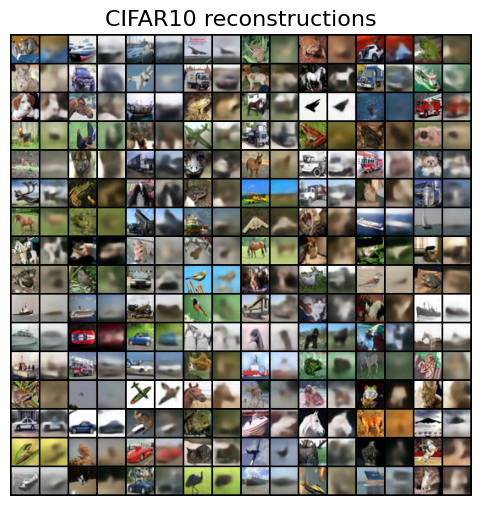

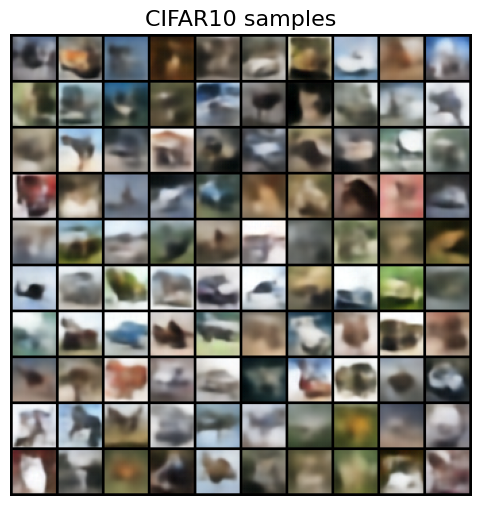

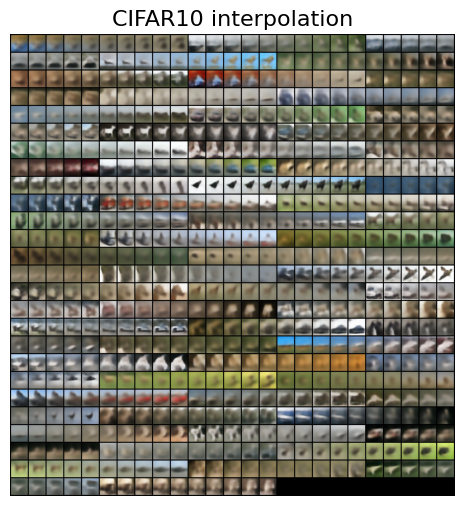

In [11]:
samples = model.sample(100)
USE_CUDA=True
x = next(iter(test_loader))[:50]
x = x[0]
# print(x.shape)
if USE_CUDA:
    x = x.to(device)

with torch.no_grad():
    z = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z[:, :N_LATENS]), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

x = next(iter(test_loader))[:20]
x = x[0].to(device)
with torch.no_grad():
    z = model.encoder(x)
    z = z[:, :N_LATENS]
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.cpu().numpy()

show_samples(reconstructions, 'CIFAR10 reconstructions')
show_samples(samples, 'CIFAR10 samples')
show_samples(interps, 'CIFAR10 interpolation')

In [13]:
TICKS_FONT_SIZE = 12
LEGEND_FONT_SIZE = 12
LABEL_FONT_SIZE = 14
TITLE_FONT_SIZE = 16

def plot_training_curves(train_losses, test_losses, logscale_y=False, logscale_x=False):
    n_train = len(train_losses[list(train_losses.keys())[0]])
    n_test = len(test_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, n_test - 1, n_train)
    x_test = np.arange(n_test)

    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + '_train')

    for key, value in test_losses.items():
        plt.plot(x_test, value, label=key + '_test')

    if logscale_y:
        plt.semilogy()
    
    if logscale_x:
        plt.semilogx()

    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.xlabel('Epoch', fontsize=LABEL_FONT_SIZE)
    plt.ylabel('Loss', fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    plt.grid()
    plt.show()

recon_loss: 14463.3924
kl_loss: 180.3281
elbo_loss: 14643.7205


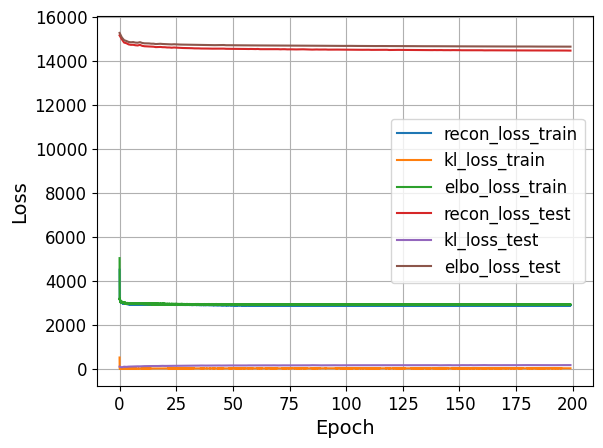

In [14]:
for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
plot_training_curves(train_losses, test_losses)